# Analyse S-Bahn München Disruptions

Twitter lets us only downloda the last ~3200 tweets and in this case we only get approx. 2500 tweets.

In [127]:
# Helpful functions
import pandas as pd
import numpy as np
import seaborn as sns

# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as cm

In [128]:
import logging
from optparse import OptionParser
import sys
from time import time

In [129]:
import re

In [130]:
sns.set()

## Datensatz: Tweets

In [131]:
tweets = pd.read_excel('tweets.xlsx')
tweets['Created At'] = pd.to_datetime(tweets['Created At'])
tweets = tweets[tweets['Tweet Type'] == 'Tweet']
tweets = tweets.drop(['Tweet Id', 'Name', 'Screen Name', 'Language', 'Client', 'Tweet Type', 'Media Type', 'URLs'], axis=1)

In [132]:
tweets.head()

,Text,Created At,Favorites,Retweets,Hashtags,Mentions
0,#Gesamtnetz: Technische Störung am Zug / Beein...,2018-02-08 10:44:55,0,0,4,0
1,#Gesamtnetz: Technische Störung am Zug behoben...,2018-02-08 10:54:42,0,0,4,0
2,#Gesamtnetz: Verkehrslage hat sich weitestgehe...,2018-02-08 11:26:50,1,1,3,0
3,#S1 #Freising / #Flughafen: Störung am Gleis /...,2018-02-08 12:34:14,2,0,5,0
4,#S7 #Kreuzstraße: Technische Störung an einem ...,2018-02-08 12:39:07,0,0,4,0


In [133]:
text = tweets['Text'].str.lower() \
    .str.replace(':', '') \
    .str.replace('#', '') \
    .str.replace('/', '') \
    .str.replace('\n', '') \
    .str.replace('.', '') \
    .str.replace(',', '') \
    .str.cat(sep=' ')
words = text.split(' ')
words = pd.DataFrame(data=np.unique(words))
words.columns = ['Word']

words['Freq'] = [text.count(w) for w in words['Word']]
words.sort_values(by='Freq', ascending=False)

#words[words['Word'].str.startswith('s')]
words[words['Word'].str.match('([s])[1-9]{1,2}', as_indexer=True)].sort_values(by='Freq', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,Word,Freq
454,s8,408
446,s2,385
453,s7,308
444,s1,240
452,s6,185
449,s3,167
450,s4,165
447,s20,17
445,s18,2
451,s46,2


In [134]:
words[words['Word'] == 'gesamtnetz']

,Word,Freq
242,gesamtnetz,74


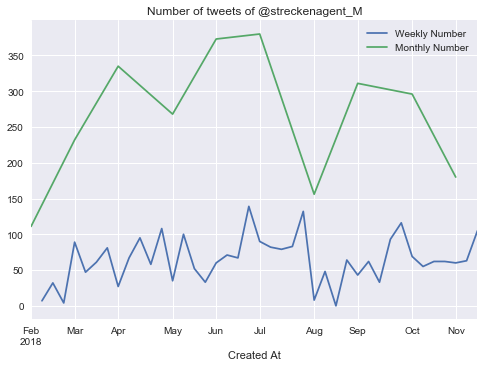

In [135]:
tweets.index = tweets['Created At']
tweets['Text'].groupby(pd.Grouper(freq='W')).count().plot()
tweets['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Number of tweets of @streckenagent_M')
plt.legend(['Weekly Number', 'Monthly Number'])
plt.savefig('num_tweets.jpg', dpi=300)

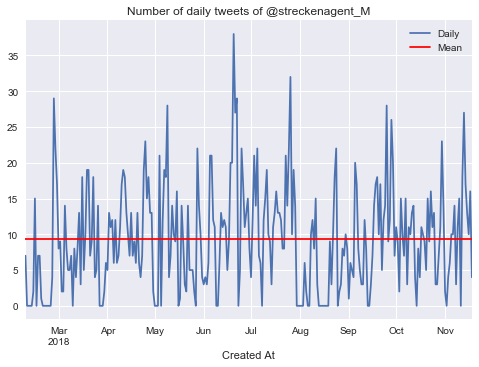

In [136]:
tweets.index = tweets['Created At']
tweets['Text'].groupby(pd.Grouper(freq='D')).count().plot(title='Number of daily tweets of @streckenagent_M')
plt.axhline(tweets['Text'].groupby(pd.Grouper(freq='D')).count().mean(), color='red')
plt.legend(('Daily', 'Mean'))

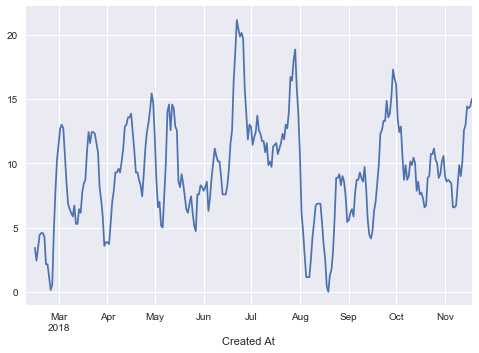

In [137]:
tweets['Text'].groupby(pd.Grouper(freq='D')).count().rolling(7).mean().plot()

## Datensatz: Störungsmelder

In [138]:
stoerungen_raw = pd.read_excel('stoerungen.xlsx')
stoerungen_raw = stoerungen_raw.drop(['id', 'meldung'], axis=1)

stoerungen_raw.columns = ['Text', 'Date']
stoerungen_raw.index = stoerungen_raw['Date']

# Error in database - take out the day
stoerungen_raw.groupby('Date').count().sort_values(by='Text', ascending=False).head(10)

,Text
Date,
2016-10-15 11:44:00,132
2016-10-18 12:47:00,21
2016-10-18 14:17:00,15
2016-10-14 21:17:00,11
2016-10-15 17:16:00,11
2016-10-15 06:08:00,9
2017-11-21 09:33:00,8
2017-11-18 07:02:00,8
2016-10-17 14:40:00,7


In [139]:
stoerungen_raw = stoerungen_raw.drop_duplicates()

In [140]:
stoerungen_raw.head()

,Text,Date
Date,,
2013-09-11 21:48:00,\n S 7 Wolfratshausen: Störung blei...,2013-09-11 21:48:00
2013-09-12 13:18:00,\n S 2 Dachau: Ausfall einzelner S-...,2013-09-12 13:18:00
2013-09-13 16:09:00,\n Information zu den Stammstrecken...,2013-09-13 16:09:00
2013-09-14 14:49:00,\n S 1 Freising/Flughafen: Technisc...,2013-09-14 14:49:00
2013-09-16 18:30:00,\n S-Bahn Stammstrecke: Verzögerung...,2013-09-16 18:30:00


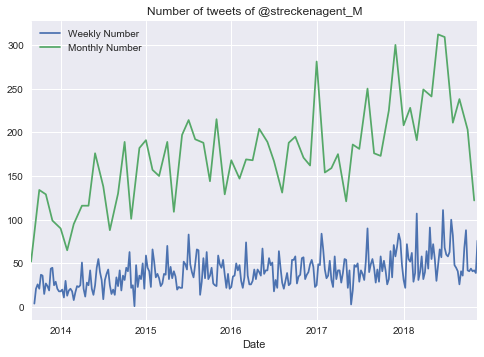

In [141]:
stoerungen_raw.index = stoerungen_raw['Date']
stoerungen_raw['Text'].groupby(pd.Grouper(freq='W')).count().plot()
stoerungen_raw['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Number of tweets of @streckenagent_M')
plt.legend(['Weekly Number', 'Monthly Number'])
plt.savefig('num_tweets.jpg', dpi=300)

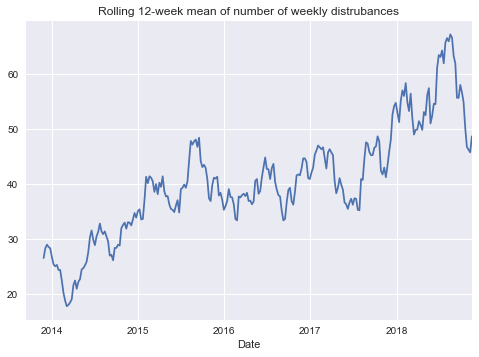

In [142]:
stoerungen_raw['Text'].groupby(pd.Grouper(freq='W')).count().rolling(12).mean().plot(title='Rolling 12-week mean of number of weekly distrubances')
plt.show()

We are partitioning all the disruption texts into parts that we can use to determine the frequency of disruptions.

In [143]:
text_split = stoerungen_raw['Text'].str.lower().str.strip()

regexp = r'(.+):{1} {1}(.*)\({1}(.+)[\)9]{0,1}'
res = text_split.str.extract(pat=regexp, expand=True)
res.columns = ['Type', 'Text', 'Date']
nantext = pd.isnull(res['Type'])
print('No match for {} entries'.format(np.sum(nantext)))

stoerungen = res[~nantext]
stoerungen.info()
stoerungen.head()

No match for 154 entries
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10773 entries, 2013-09-11 21:48:00 to 2018-11-18 12:05:00
Data columns (total 3 columns):
Type    10773 non-null object
Text    10773 non-null object
Date    10773 non-null object
dtypes: object(3)
memory usage: 336.7+ KB


,Type,Text,Date
Date,,,
2013-09-11 21:48:00,s 7 wolfratshausen,störung bleibt bestehen,"11.09.13, 21:50 uhr)"
2013-09-12 13:18:00,s 2 dachau,ausfall einzelner s-bahnen des 10-minuten-takts,"stand 12.09.13, 13:20 uhr)"
2013-09-14 14:49:00,s 1 freising/flughafen,technische störung an einem stelllwerk / s-bah...,"stand 14.09.2013, 14:50 uhr)"
2013-09-16 18:30:00,s-bahn stammstrecke,verzögerungen,"stand, 16.09.2013; 18:30 uhr)"
2013-09-16 18:47:00,s 2 petershausen,sperrung zwischen allach und dachau von ca. 20...,"stand 16.09.2013, 18:45 uhr)"


In [224]:
stoerungen_without_10mtakt = stoerungen[~stoerungen['Text'].str.contains('10-minuten-takt')]

# types = np.unique(stoerungen['Type'])
types = np.unique(stoerungen_without_10mtakt['Type'])
types_freq = pd.DataFrame({'Words': types, 'Freq': [np.sum(stoerungen_without_10mtakt['Type'] == typ) for typ in types]})

Filter out all the "Aktualisierungen" as these are of course related to the severence of the disruption but we do not want to have duplicates.

In [225]:
types_freq['Keep'] = ~types_freq['Words'].str.contains('aktualisierung')

In [226]:
types_freq[types_freq['Keep']].sort_values(by='Freq', ascending=False)

,Freq,Words,Keep
1101,1141,stammstrecke,True
989,361,s 7 wolfratshausen,True
816,308,s 2 erding,True
775,283,s 1 freising/flughafen,True
1010,243,s 8 herrsching,True
769,226,s 1 freising / flughafen,True
931,225,s 4 geltendorf,True
981,214,s 7 kreuzstraße,True
887,193,s 3 holzkirchen,True
924,188,s 4 ebersberg,True


In [227]:
sbahnlinien = ['1', '2', '3', '4', '6', '7', '8']
mentions = dict()

for sbahnlinie in sbahnlinien:
    mentions['S{}'.format(sbahnlinie)] = types_freq['Freq'][(types_freq['Words'].str.contains('s {}'.format(sbahnlinie)) | types_freq['Words'].str.contains('s{}'.format(sbahnlinie))) & types_freq['Keep']].sum()

freq = pd.Series(list(mentions.values()))
sbahnlinie = pd.Series(list(mentions.keys()))
m = pd.concat([sbahnlinie, freq], axis=1)
m.columns = ['S-Bahnlinie', 'Mentions']
m

,S-Bahnlinie,Mentions
0,S1,719
1,S2,837
2,S3,457
3,S4,622
4,S6,400
5,S7,822
6,S8,622


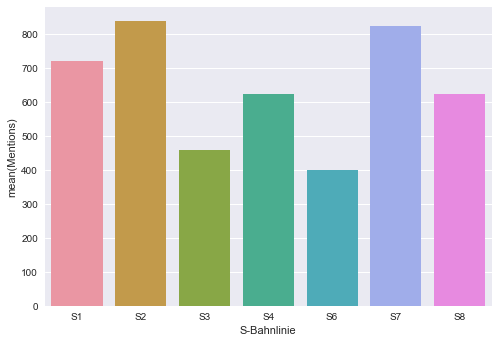

In [228]:
sns.barplot(x='S-Bahnlinie', y='Mentions', data=m)

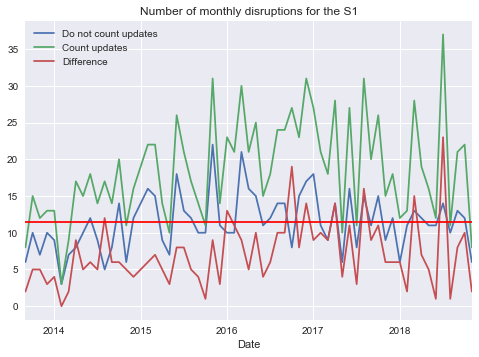

In [210]:
sbahnlinie = '1'

monthly_stoerungen_without_updates = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) | stoerungen['Type'].str.contains('s{}'.format(sbahnlinie))) & ~stoerungen['Type'].str.contains('aktualisierung')] \
    .groupby(pd.Grouper(freq='M')).count()
monthly_stoerungen = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) | stoerungen['Type'].str.contains('s{}'.format(sbahnlinie)))] \
    .groupby(pd.Grouper(freq='M')).count()

monthly_stoerungen_without_updates.plot(label='Do not count updates')
monthly_stoerungen.plot(title='Number of monthly disruptions for the S{}'.format(sbahnlinie), label='Count updates')

(monthly_stoerungen - monthly_stoerungen_without_updates).plot(label='Difference')

plt.legend()
plt.axhline(y=monthly_stoerungen_without_updates.mean(), color='red')
plt.show()

For the S2 and S8 you have to take out the messages around the "10-Minuten-Takt" as they are irrelevant to us and rather small disruptions that occur frequently.

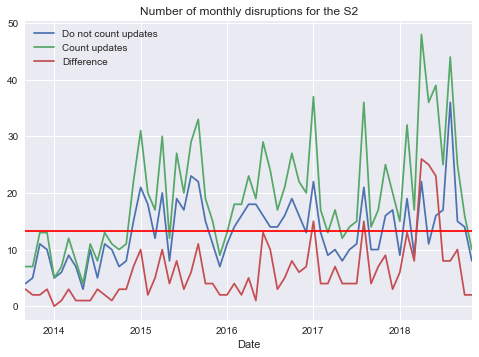

In [211]:
sbahnlinie = '2'

monthly_stoerungen_without_updates = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) | stoerungen['Type'].str.contains('s{}'.format(sbahnlinie))) \
                                                        & ~stoerungen['Type'].str.contains('aktualisierung') & ~stoerungen['Text'].str.contains('10-minuten-takt')] \
    .groupby(pd.Grouper(freq='M')).count()
monthly_stoerungen = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) | stoerungen['Type'].str.contains('s{}'.format(sbahnlinie))) \
                                        & ~stoerungen['Text'].str.contains('10-minuten-takt')] \
    .groupby(pd.Grouper(freq='M')).count()

monthly_stoerungen_without_updates.plot(label='Do not count updates')
monthly_stoerungen.plot(title='Number of monthly disruptions for the S{}'.format(sbahnlinie), label='Count updates')

(monthly_stoerungen - monthly_stoerungen_without_updates).plot(label='Difference')

plt.legend()
plt.axhline(y=monthly_stoerungen_without_updates.mean(), color='red')
plt.show()

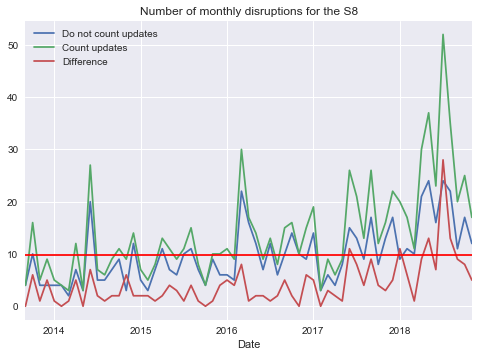

In [212]:
sbahnlinie = '8'

monthly_stoerungen_without_updates = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) | stoerungen['Type'].str.contains('s{}'.format(sbahnlinie))) \
                                                        & ~stoerungen['Type'].str.contains('aktualisierung') & ~stoerungen['Text'].str.contains('10-minuten-takt')] \
    .groupby(pd.Grouper(freq='M')).count()
monthly_stoerungen = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) | stoerungen['Type'].str.contains('s{}'.format(sbahnlinie))) \
                                        & ~stoerungen['Text'].str.contains('10-minuten-takt')] \
    .groupby(pd.Grouper(freq='M')).count()

monthly_stoerungen_without_updates.plot(label='Do not count updates')
monthly_stoerungen.plot(title='Number of monthly disruptions for the S{}'.format(sbahnlinie), label='Count updates')

(monthly_stoerungen - monthly_stoerungen_without_updates).plot(label='Difference')

plt.legend()
plt.axhline(y=monthly_stoerungen_without_updates.mean(), color='red')
plt.show()

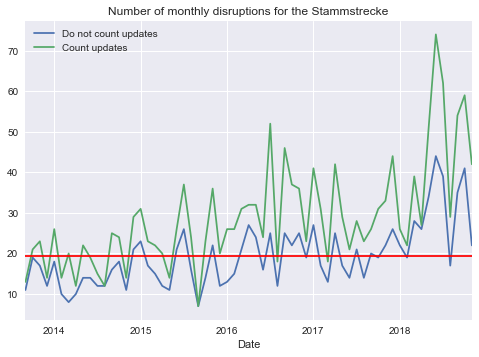

In [213]:
monthly_stoerungen_without_updates = stoerungen['Type'][(stoerungen['Type'].str.contains('stammstrecke')) & ~stoerungen['Type'].str.contains('aktualisierung')] \
    .groupby(pd.Grouper(freq='M')).count()
monthly_stoerungen = stoerungen['Type'][stoerungen['Type'].str.contains('stammstrecke')] \
    .groupby(pd.Grouper(freq='M')).count()

monthly_stoerungen_without_updates.plot(label='Do not count updates')
monthly_stoerungen.plot(title='Number of monthly disruptions for the Stammstrecke'.format(sbahnlinie), label='Count updates')

plt.legend()
plt.axhline(y=monthly_stoerungen_without_updates.mean(), color='red')
plt.show()